In [4]:
import os
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt

import utils
import orb

In [5]:
cv2.__version__

'3.4.2'

In [6]:
# 8730A.097.A.TIF
# 8619A.004.A.TIF

root = '/data1/huangkaibin/Data/karyotype/origin/data'
target = "/data1/huangkaibin/Data/karyotype/origin_split/"

patient_info, img_a, img_k = [], [], []

for name in os.listdir(root):
    if "A.TIF" in name:
        img_a.append(name)
    elif "K.TIF" in name:
        img_k.append(name)
    else:
        patient_info.append(name)
        
img_a.sort()
img_k.sort()

In [8]:
for name in img_a:
    os.system("cp {} {}".format(os.path.join(root, name), os.path.join(target, 'a', name)))

In [ ]:
for name in img_k:
    os.system("cp {} {}".format(os.path.join(root, name), os.path.join(target, 'k', name)))

In [7]:
print(f"number of image pair A: {len(img_a)} / K: {len(img_k)}")

# check pair
for na in img_a:
    nk = na.replace("A.TIF", "K.TIF")
    if not nk in img_k:
        os.system("rm {}".format(os.path.join(target, 'a', na)))

# info show
# num of image
img_a = sorted(list(os.listdir(os.path.join(target, 'a_crop'))))
img_k = sorted(list(os.listdir(os.path.join(target, 'k'))))
print(f"number of image pair A: {len(img_a)} / K: {len(img_k)}")

# num of patient
p_ids = set([name[:5] for name in img_a])
print(f"number of patient: {len(p_ids)}")

number of image pair A: 2475 / K: 2463
number of image pair A: 2475 / K: 2463
number of image pair A: 2463 / K: 2463
number of patient: 93
number of image pair A: 2463 / K: 2463
number of patient: 93


In [3]:
root = '/data1/huangkaibin/Data/karyotype/origin_split/'

img_name_a = sorted([os.path.join(root, 'a', name) for name in os.listdir(os.path.join(root, 'a'))])

#crop image_a and save
for na in img_name_a:
    ia = cv2.imread(na, 0)
    x0, x1, y0, y1 = utils.crop_a(ia)
    try:
        cv2.imwrite(na.replace('/a/', '/a_crop/'), ia[x0:x1, y0:y1])
    except:
        cv2.imwrite(na.replace('/a/', '/a_crop/'), ia)
        print(na)

In [8]:
img_crop_path = '/data1/huangkaibin/Data/karyotype/origin_split/a_crop/'

for name in os.listdir(img_crop_path):
    img = cv2.imread(os.path.join(img_crop_path, name))
    x, y = img.shape[:2]
    if x > y:
        print(name)

8602A.121.A.TIF
8602A.121.A.TIF


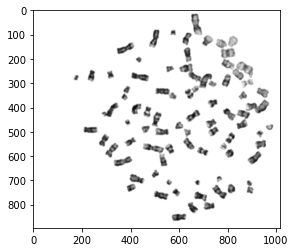

In [ ]:
img_path = '/data1/huangkaibin/Data/karyotype/origin_split/a/'
img = cv2.imread(os.path.join(img_path, '8602A.121.A.TIF'))
plt.imshow(img)
plt.show()

In [3]:
def orb_match(src, tar):
    detector = cv2.ORB_create(10000)
    kpts1 = detector.detect(src, None)
    kpts2 = detector.detect(tar, None)

    descriptor = cv2.xfeatures2d.BEBLID_create(0.75)

    kpts1, desc1 = descriptor.compute(src, kpts1)
    kpts2, desc2 = descriptor.compute(tar, kpts2)

    matcher = cv2.DescriptorMatcher_create(cv2.DescriptorMatcher_BRUTEFORCE_HAMMING)
    nn_matches = matcher.knnMatch(desc1, desc2, 2)

    return kpts1, kpts2, nn_matches

In [6]:
def surf_match(src, tar):
    detector = cv2.xfeatures2d.SURF_create(10000)
    kpts1, desc1 = surf.detectAndCompute(src, None)
    kpts2, desc2 = surf.detectAndCompute(tar, None)

    matcher = cv2.DescriptorMatcher_create(cv2.DescriptorMatcher_BRUTEFORCE_HAMMING)
    nn_matches = matcher.knnMatch(desc1, desc2, 2)
    
    return kpts1, kpts2, nn_matches

In [74]:
import skimage
from skimage.measure import label, regionprops

# 分割k图的染色体 并且处理粘连的子染色体
img_k_path = '/data1/huangkaibin/Data/karyotype/origin_split/k/'
img_k_name = sorted(list(os.listdir(img_k_path)))

img_sub_k_path = '/data1/huangkaibin/Data/karyotype/origin_split/sub_k_221216/'
os.makedirs(img_sub_k_path, exist_ok=True)

for name in img_k_name:
    img = cv2.imread(os.path.join(img_k_path, name), 0)
    
#     cls_bottom_pts = utils.calc_bottom_pt(img)
    
    i = 1
    
    msk = utils.threshold_segm(img, 250)

    for prop in regionprops(label(msk)):
#         sub_img = utils.show_spec_area(img, prop.bbox, 255)
#         sub_msk = utils.show_spec_area(msk, prop.bbox, 0)
#         cls = utils.get_cls_from_pt(cls_bottom_pts, prop.bbox)
        sub_img = img[prop.bbox[0]:prop.bbox[2], prop.bbox[1]:prop.bbox[3]]
        sub_msk = msk[prop.bbox[0]:prop.bbox[2], prop.bbox[1]:prop.bbox[3]]
        if sub_msk.sum()/255 > 200:
#             x, y = sub_msk.shape[:2]
    #         sub_msk_proj = np.array([sum(sub_msk[:, j])/x for j in range(y)])
    #         plt.plot(sub_msk_proj)
    #         plt.show()
            sub_msk = utils.fill_holes(sub_msk)
            
            kernel = np.ones((5, 5), np.uint8)
            erode_mask = cv2.erode(sub_msk, kernel)
            
            labels = label(erode_mask)
            props  = regionprops(labels)
            
            if len(props) > 1:
                
                obj_ids = np.unique(labels)
                obj_ids = obj_ids[1:]
                labels = labels == obj_ids[:, None, None]
                
                for l in labels:
                    l = cv2.dilate(255*l.astype(np.uint8), kernel)
                    px, py = np.where(l)
                    px.sort()
                    py.sort()
                    
                    if l.sum()/255 > 200:
                        cv2.imwrite(
                            os.path.join(img_sub_k_path, name.replace('.TIF', f'.{str(i).zfill(3)}.TIF')), 
                                    sub_img[px[0]:px[-1], py[0]:py[-1]])
                        cv2.imwrite(
                            os.path.join(img_sub_k_path, name.replace('.TIF', f'.{str(i).zfill(3)}_msk.TIF')), 
                                    sub_msk[px[0]:px[-1], py[0]:py[-1]])
                        i += 1
            else:
                cv2.imwrite(os.path.join(img_sub_k_path, name.replace('.TIF', f'{str(i).zfill(2)}.TIF')), sub_img)
                cv2.imwrite(os.path.join(img_sub_k_path, name.replace('.TIF', f'{str(i).zfill(2)}_msk.TIF')), sub_msk)
                i += 1

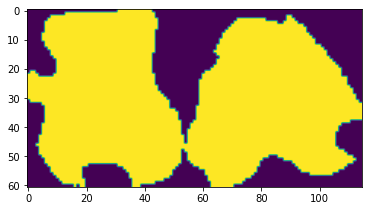

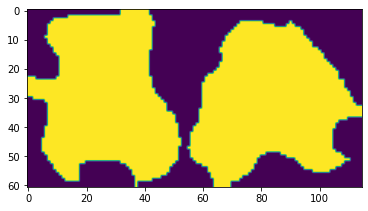

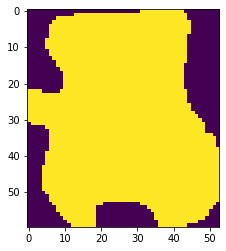

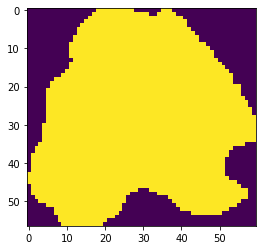

In [62]:
# load mask
mask = cv2.imread('/data1/huangkaibin/Data/karyotype/origin_split/sub_k/111377_msk.png', 0)
plt.imshow(mask)
plt.show()

# erode
kernel = np.ones((3, 3), np.uint8)
mask_erode = cv2.erode(mask, kernel)
plt.imshow(mask_erode)
plt.show()

# 
labels = label(mask_erode)
props = regionprops(labels)
    
obj_ids = np.unique(labels)
obj_ids = obj_ids[1:]
labels = labels == obj_ids[:, None, None]
for l in labels:
    l = cv2.dilate(l.astype(np.uint8), kernel)
    px, py = np.where(l)
    px.sort()
    py.sort()
    plt.imshow(l[px[0]:px[-1], py[0]:py[-1]])
    plt.show()

In [ ]:
# folder0
# --folder1--8602A.121
# ----8602A.121.A.TIF
# ----8602A.121.K.TIF
# ----folder2--sub_masks (sub-mask for check and refine) with class info